In [1]:
import pandas as pd
import numpy as np
import pyemma as pm
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import pickle as p

## Introduction

This notebook makes a simple MSM from the phi, psi, and chi dihedrals defined in `create_features`. I'll use the 'D' active site data as default and then check on the 'H' site. 


## Data

In [2]:
X = [np.load('../data/MD/dihedrals/as_d_{}_sincos.npy'.format(x+1)) for x in range(100)]

In [3]:
X[1].shape

(10000, 116)

In [4]:
dt = 100/X[1].shape[0]
dt

0.01

## Preprocess

This can take a long time.  Skip this if already run. 

TICA

In [16]:
ys = []
for i, lag in enumerate([0.01, 0.1, 1, 10]):
    tica = pm.coordinates.tica(X, lag=int(lag/dt))
    Y = tica.get_output()
    ys.append(np.concatenate(Y))

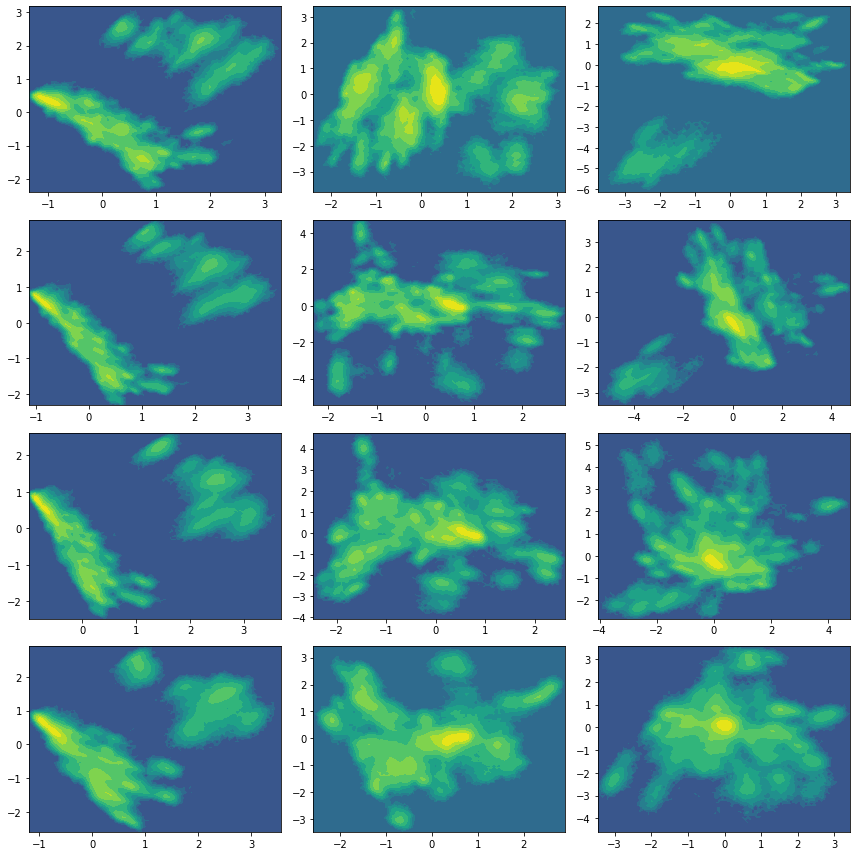

In [28]:
fig, axes = plt.subplots(4,3, figsize=(12, 12))

for j in range(3):
    for i in range(4):
        pm.plots.plot_free_energy(ys[i][:, 0+j], ys[i][:, 1+j], ax=axes[i, j], levels=np.arange(14), 
                                 cmap='viridis_r', avoid_zero_count=True, cbar=False)

plt.tight_layout()
    

In [31]:
tica = pm.coordinates.tica(X, lag=int(0.1/dt), dim=10)
Y = tica.get_output()

Cluster

In [76]:
k = np.sqrt(X[0].shape[0]*len(X)).astype(int)
print(k)
cluster = pm.coordinates.cluster_mini_batch_kmeans(data=Y, k=330, max_iter=1000)
dtrajs = cluster.dtrajs


1000


10-04-20 18:39:32 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[75] INFO     Cluster centers converged after 60 steps.


In [40]:
p.dump(file=open('reference_model_dihedrals/as_d_cluster.p', 'wb'), obj=cluster)

Compute its vs lags

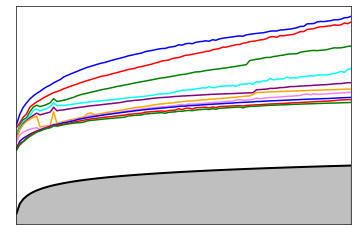

In [102]:
lags = np.arange(1, 200, 2).astype(int)
its = pm.msm.its(dtrajs, lags = lags, nits=10)

pm.plots.plot_implied_timescales(its, dt=dt, units='ns')

p.dump(file=open('reference_model_dihedrals/as_d_its_2.p', 'wb'), obj={'lags': its.lags, 'timescales': its.timescales})

In [103]:
lags = np.arange(100, 2000, 100).astype(int)
its = pm.msm.its(dtrajs, lags = lags, nits=10)

pm.plots.plot_implied_timescales(its, dt=dt, units='ns')

p.dump(file=open('reference_model_dihedrals/as_d_its_20.p', 'wb'), obj={'lags': its.lags, 'timescales': its.timescales})

KeyboardInterrupt: 

## Fit model
if previous code as run just start here. 


In [51]:
# cluster = p.load(file=open('reference_model/as_d_cluster.p', 'rb'))
# dtrajs = cluster.dtrajs

In [87]:
# mm01 = pm.msm.estimate_markov_model(dtrajs, lag = int(0.1/dt))
mm = pm.msm.estimate_markov_model(dtrajs, lag = int(2/dt))

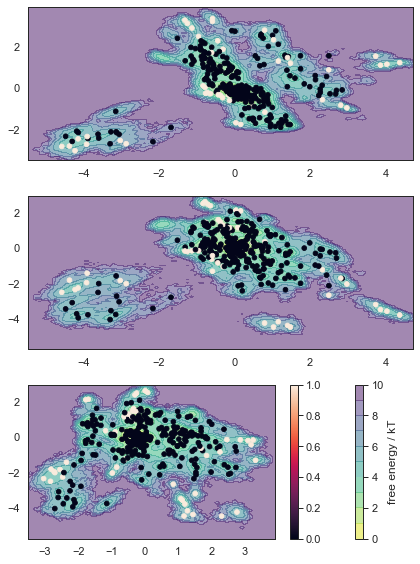

In [101]:
with sns.plotting_context('paper', font_scale=1.25):
    fig = plt.figure(figsize=(6,8))
    sns.set_style('white')
    m = mm
    for ix, (i, j) in enumerate([[0, 1], [0, 2], [1, 2]]):
        ax = fig.add_subplot(3,1, ix+1)
        if ix == 2:
            cbar=True
        else: 
            cbar=False
#         plot(i, j, 'H', )
        pm.plots.plot_free_energy(np.concatenate(Y)[:, i+2], np.concatenate(Y)[:, j+2], cmap='viridis_r', 
                                  **{'avoid_zero_count': True, 'levels': [0,1,2,3,4,5, 6,7, 8, 9, 10], 
                           'ax': ax, 'cbar': cbar, 'alpha':0.5})
        
        c = ax.scatter(cluster.cluster_centers_[m.active_set, i+2], 
                       cluster.cluster_centers_[m.active_set, j+2], 
                       c=(m.eigenvectors_right()[:, 7]>0),
                      alpha=1)
        if ix==2:
            plt.colorbar(c)
        
    plt.tight_layout()